<a href="https://colab.research.google.com/github/CS418/group-project-jelabi/blob/main/418_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [2]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import scipy as sc
import math
import io
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sbn

import pandas as pd
!pip install sodapy
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit=200000)

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
dfOriginal.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-10-25T23:59:00.000,"{'latitude': '41.976865783', 'human_address': ...",020,052XX N WINTHROP AVE,1934884,41.976865783,OVER $500,APARTMENT,2022-11-01T16:46:59.000,77,...,48,JF450367,2022,False,06,-87.657827653,2023,THEFT,False,12872409
1,2022-10-25T23:42:00.000,"{'latitude': '41.897506529', 'human_address': ...",012,026XX W IOWA ST,1905893,41.897506529,TELEPHONE THREAT,BAR OR TAVERN,2022-11-01T16:46:59.000,24,...,26,JF449574,2022,False,08A,-87.692435013,1211,OTHER OFFENSE,False,12871809
2,2022-10-25T23:41:00.000,"{'latitude': '41.722938321', 'human_address': ...",006,094XX S BURNSIDE AVE,1842469,41.722938321,TO PROPERTY,RESIDENCE,2022-11-01T16:46:59.000,44,...,9,JF449544,2022,False,14,-87.605935366,0633,CRIMINAL DAMAGE,False,12871781
3,2022-10-25T23:37:00.000,"{'latitude': '41.883007148', 'human_address': ...",012,023XX W WASHINGTON BLVD,1900624,41.883007148,POSSESS - SYNTHETIC DRUGS,SIDEWALK,2022-11-01T16:46:59.000,28,...,27,JF449560,2022,False,18,-87.685312534,1223,NARCOTICS,True,12871794
4,2022-10-25T23:34:00.000,"{'latitude': '41.875915206', 'human_address': ...",011,003XX S HAMLIN BLVD,1897969,41.875915206,DOMESTIC BATTERY SIMPLE,APARTMENT,2022-11-01T16:46:59.000,26,...,28,JF449547,2022,True,08B,-87.720663353,1133,BATTERY,False,12871798


Data Cleaning

In [3]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on']) #Cleaning by dropping unneeded columns

In [4]:
# Merging certain similar features
df.loc[df["primary_type"] == "MOTOR VEHICLE THEFT", "primary_type"] = "THEFT"
df.loc[df["primary_type"] == "CRIMINAL SEXUAL ASSAULT", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "BATTERY", "primary_type"] = "ASSAULT"
df.loc[df["primary_type"] == "CRIMINAL TRESPASS", "primary_type"] = "BURGLARY"
df.loc[df["primary_type"] == "INTERFERENCE WITH PUBLIC OFFICER", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "OBSCENITY", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "PUBLIC INDECENCY", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION", "primary_type"] = "WEAPONS VIOLATION"
df.loc[df["primary_type"] == "OTHER NARCOTIC VIOLATION", "primary_type"] = "NARCOTICS"

df.isna().sum().sum() #Drop rows with any missing values, very small amount of data


7513

Data Visualization

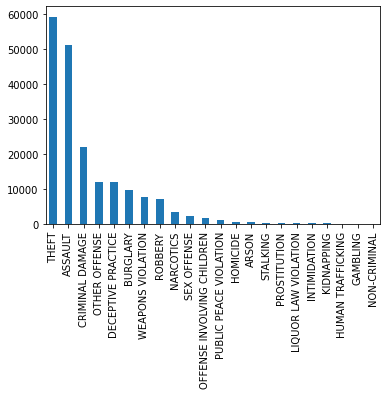

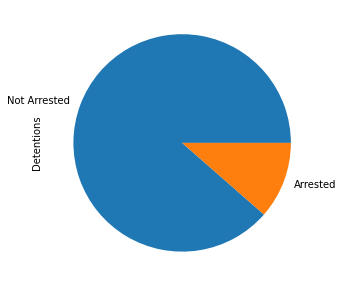

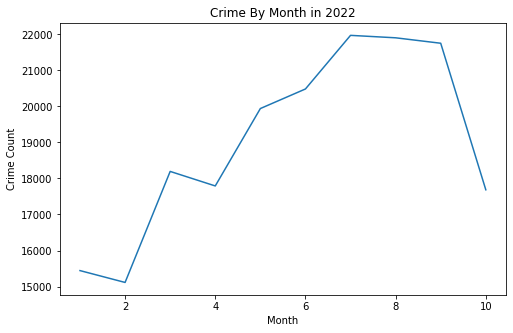

In [5]:
df['primary_type'].value_counts().plot(kind='bar')
plt.show()


arrest_df = df['arrest'].value_counts()
arrest_count = (arrest_df / df['arrest'].sum())
arrest_count.rename("Detentions",inplace=True)
arrest_count.rename({True: 'Arrested', False: 'Not Arrested'},inplace=True)
arrest_count.plot.pie(y=1, figsize=(5, 5))
plt.show()

crimeDate = df.copy(deep=True)
crimeDate.date = pd.to_datetime(crimeDate.date, format = '%Y-%m-%dT%H:%M:%S.000')
crimeDate.index = pd.DatetimeIndex(crimeDate.date)

plt.figure(figsize = (8,5))
crimeDate.groupby([crimeDate.index.month]).size().plot.line()

plt.title('Crime By Month in 2022')
plt.ylabel('Crime Count')
plt.xlabel('Month')
plt.show()